Dimensionality Reduction
---
##### 14Dec2018
Using discrete (`inputs/GSM1626793_P14Retina_1.digital_expression.csv.gz`, Mocosko, _et al_ 2015) and continuous (`inputs/qi_s1_edited_all.csv.gz`) datasets, downsample and feature select, then perform various DR techniques and compare the following:
* __Euclidean cell-cell distance__ correlations before and after transformation/reduction
* __Kullback-Leibler Divergence (KLD)__ explaining the Shannon entropy of the difference between the cumulative probability distributions of unique, normalized cell-cell distances.
* __K-nearest neighbor (Knn)__ preservation

In [1]:
import sys
sys.path.append('../')
from fcc_DRs import *
from fcc_utils import *

Using TensorFlow backend.
/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/kopt/config.py:60: YAMLLoadWarning: 
  *** Calling yaml.load() without Loader=... is deprecated.
  *** The default Loader is unsafe.
  *** Please read https://msg.pyyaml.org/load for full details.
  _config = yaml.load(open(_config_path))


---
#### 0. read in discrete dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30
* _cluster_ and _downsample proportionally_ for future processing

In [2]:
P14Retina = RNA_counts.from_file('../inputs/GSM1626793_P14Retina_1.digital_expression.csv.gz', cells_axis=1, labels=[0,0])

In [3]:
P14Retina.data.shape

(6600, 20478)

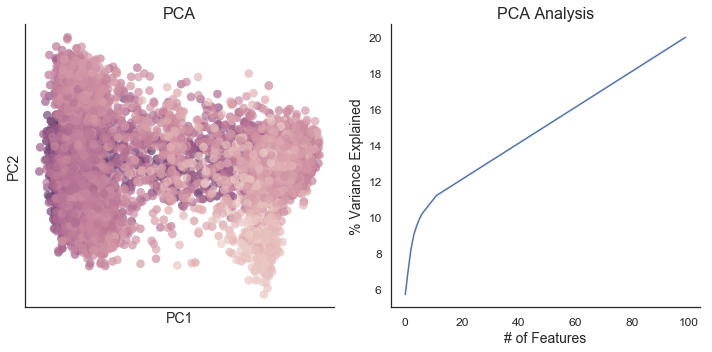

In [5]:
P14Retina_PCA100 = fcc_PCA(P14Retina.arcsinh_norm(norm='l1'), n_components=100)
P14Retina_PCA100.plot()

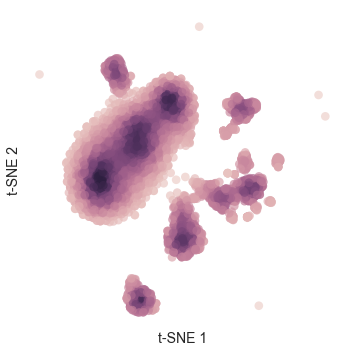

CPU times: user 1min 5s, sys: 2.84 s, total: 1min 8s
Wall time: 1min 9s


In [6]:
%%time 
P14Retina_tSNE = fcc_tSNE(P14Retina_PCA100.results, perplexity=30) # use standard perplexity of 30 here
P14Retina_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x136256828>)

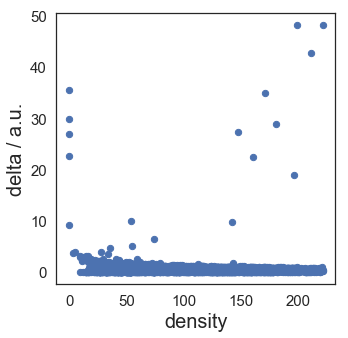

In [7]:
P14Retina_tSNE.clu.draw_decision_graph() # get potential density-peak cluster centers

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13496b278>)

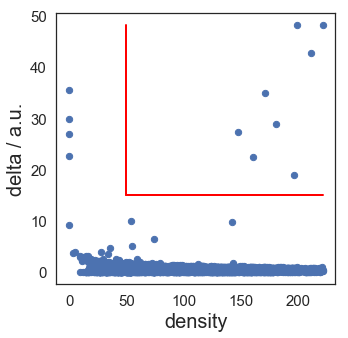

In [8]:
P14Retina_tSNE.clu.assign(50,15) # assign cluster center cutoffs
P14Retina_tSNE.clu.draw_decision_graph(min_delta=P14Retina_tSNE.clu.min_delta, min_density=P14Retina_tSNE.clu.min_density) # plot chosen density-peak cluster centers

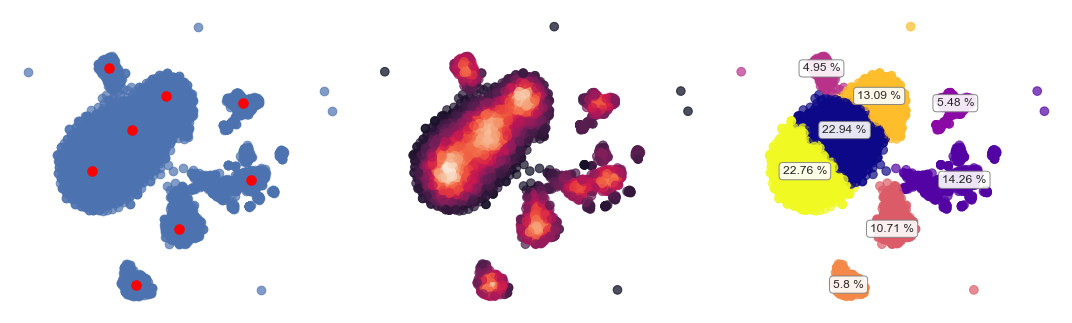

In [9]:
P14Retina_tSNE.plot_clusters() # visualize clustering

In [10]:
print('Silhouette Score: {}\n'.format(P14Retina_tSNE.silhouette_score()))

Silhouette Score: 0.5186678171157837



---
#### 1. subsample discrete dataset and perform DRs
* select _500 most variable genes_
* downsample to _1000 cells_ with _proportional representation from prior clustering_
* _500-component PCA_ as control comparison to _feature-selected counts data_
* _2-component_ PCA
* _t-SNE_ with perplexity 30
* _UMAP_ with perplexity 30
* _DCA_

In [11]:
# select 500 most variable genes
P14Retina_varselect = RNA_counts.var_select(P14Retina, n_features=500) 

In [12]:
# choose 1000 cells with proportional representation from clusters above
P14Retina_0 = RNA_counts.downsample_proportional(P14Retina_varselect, P14Retina_tSNE.clu.membership, n_cells=1000, seed=10)

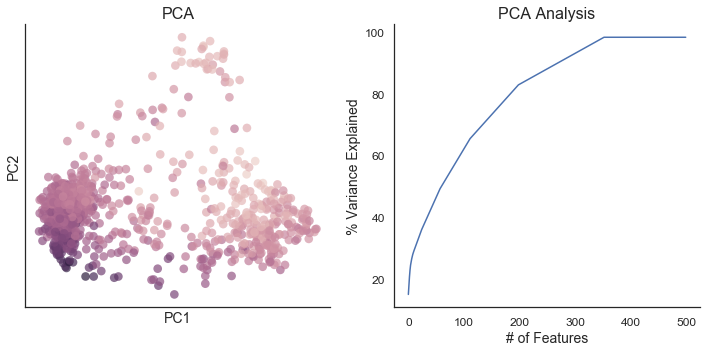

In [13]:
P14Retina_0_PCA500 = fcc_PCA(P14Retina_0.arcsinh_norm(norm='l1'), n_components=500) # 500 component PCA as control
P14Retina_0_PCA500.plot()

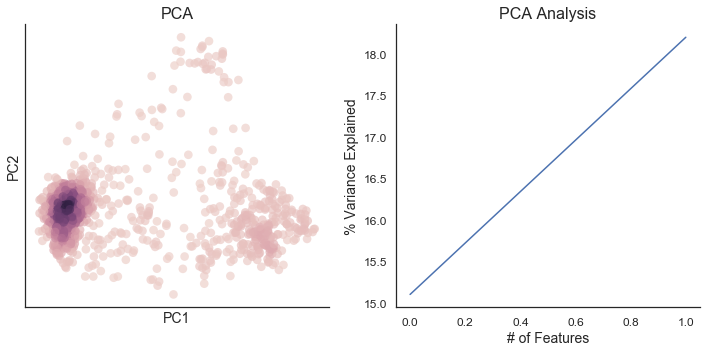

In [14]:
P14Retina_0_PCA2 = fcc_PCA(P14Retina_0.arcsinh_norm(norm='l1'), n_components=2) # 2 component PCA
P14Retina_0_PCA2.plot()

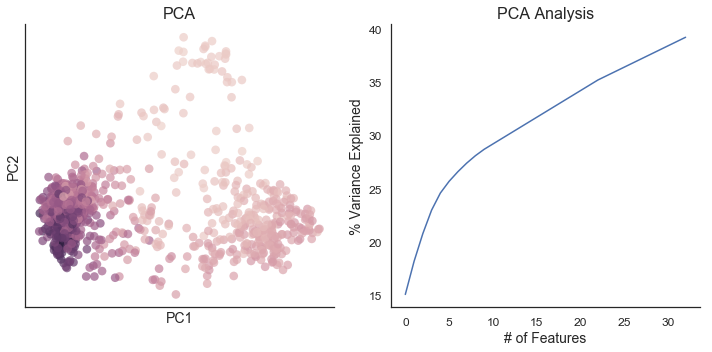

In [15]:
P14Retina_0_PCA33 = fcc_PCA(P14Retina_0.arcsinh_norm(norm='l1'), n_components=33) # 33 component PCA
P14Retina_0_PCA33.plot()

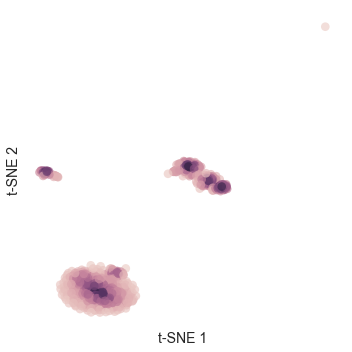

In [16]:
P14Retina_0_tSNE = fcc_tSNE(P14Retina_0.arcsinh_norm(norm='l1'), perplexity=30) # t-SNE with perplexity 30
P14Retina_0_tSNE.plot()

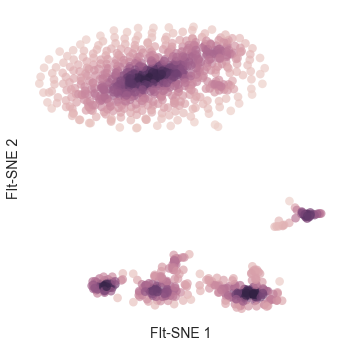

In [63]:
P14Retina_0_FItSNE = fcc_FItSNE(P14Retina_0.arcsinh_norm(norm='l1'), perplexity=30, seed=11) # t-SNE with perplexity 30
P14Retina_0_FItSNE.plot()

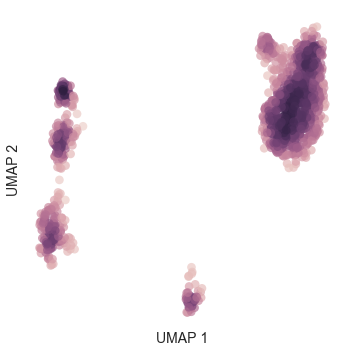

In [18]:
P14Retina_0_UMAP = fcc_UMAP(P14Retina_0.arcsinh_norm(norm='l1'), perplexity=30) # UMAP with perplexity 30
P14Retina_0_UMAP.plot()

In [19]:
%time P14Retina_0_DCA = fcc_DCA(P14Retina_0.counts, norm=False) # DCA on raw counts of 500 selected features

DCA: Successfully preprocessed 500 genes and 1004 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 19.2 s, sys: 892 ms, total: 20.1 s
Wall time: 11.5 s


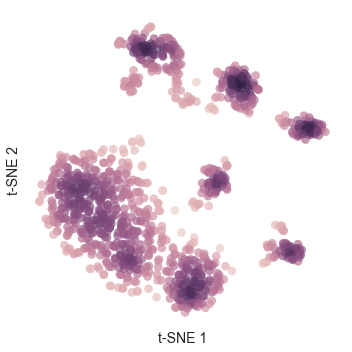

In [20]:
test = RNA_counts(data=P14Retina_0_DCA.results)
P14Retina_0_DCAtSNE = fcc_tSNE(test.arcsinh_norm(norm='l1'), perplexity=30) # t-SNE with perplexity 30
P14Retina_0_DCAtSNE.plot()

##### Use scVI to reduce dimensions

In [1]:
from scvi.dataset import CsvDataset
import urllib
from scvi.models import *
from scvi.inference import UnsupervisedTrainer
n_epochs=400 
lr=1e-3
use_batches=False
use_cuda=True

In [9]:
# Loading a local dataset into scVI
P14Retina1_scVI = CsvDataset('GSM1626793_P14Retina_1.digital_expression.csv.gz', 
                               save_path='inputs/', compression='gzip') 

File inputs/GSM1626793_P14Retina_1.digital_expression.csv.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 20478 to 600 genes
Downsampling from 6600 to 6600 cells


In [11]:
vae = VAE(P14Retina1_scVI.nb_genes, n_batch=P14Retina1_scVI.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              P14Retina1_scVI,
                              train_size=0.75,
                              use_cuda=use_cuda,
                              frequency=5)
trainer.train(n_epochs=n_epochs, lr=lr)

training: 100%|████████████████████████████████████████████████████████████████████████████| 400/400 [08:55<00:00,  1.77s/it]


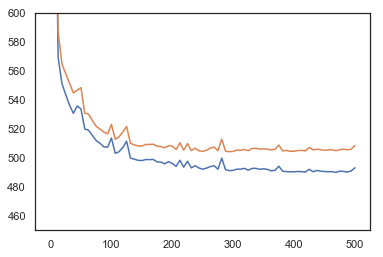

In [15]:
ll_train_set = trainer.history["ll_train_set"]
ll_test_set = trainer.history["ll_test_set"]
x = np.linspace(0,500,(len(ll_train_set)))
plt.plot(x, ll_train_set)
plt.plot(x, ll_test_set)
plt.ylim(450,600)
plt.show()

---
#### 2. compare Euclidean distances and Knn preservation before and after DR transformations
* _arcsinh-transform counts_ before calculating distance matrices for fair comparison to DR outputs
* for DCA, _do not arcsinh-transform_ because raw counts are input

In [60]:
# reload functions when editing file
del sys.modules['fcc_DRs']
from fcc_DRs import *

In [22]:
k = 30 # choose value for K-nearest neighbor calculations

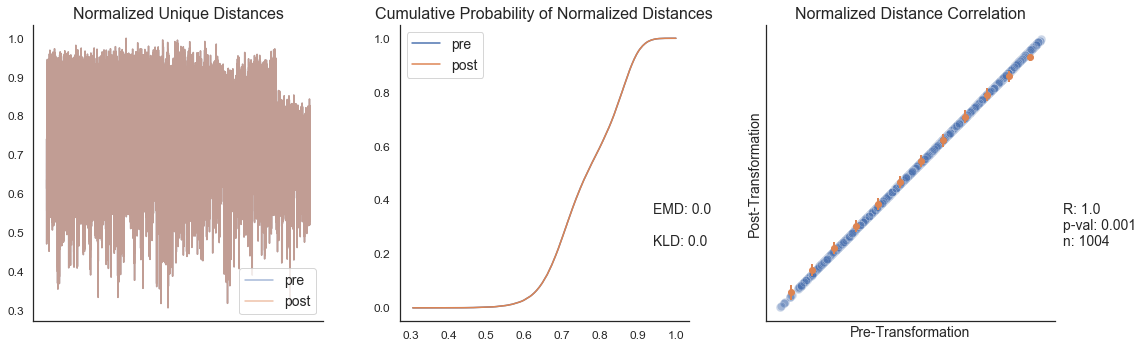

Knn Preservation: 100.0

CPU times: user 31.9 s, sys: 4.46 s, total: 36.4 s
Wall time: 35.9 s


In [23]:
%%time
# look at 500-component PCA vs 500-feature dataset as control. should have perfect correlation and EMD/KLD.
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA500.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA500.knn_graph(k))))

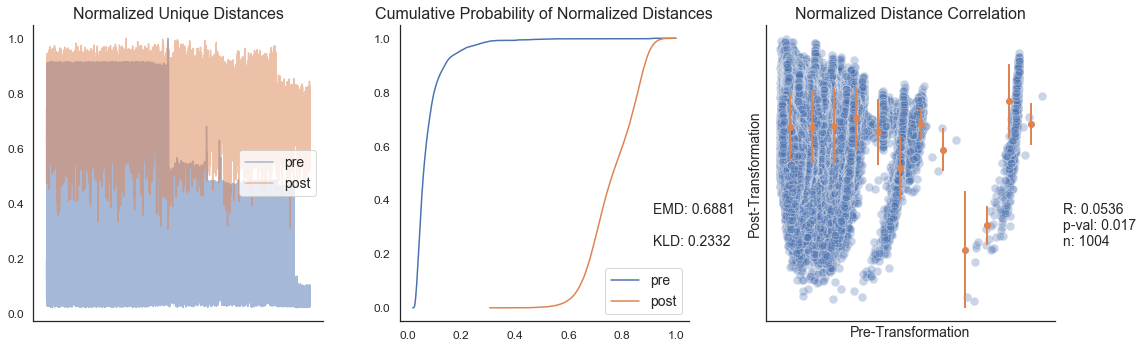

Knn Preservation: 95.5786

CPU times: user 32.3 s, sys: 4.15 s, total: 36.4 s
Wall time: 36 s


In [24]:
%%time
# look at arcsinh-transformed vs raw dataset to see how correlation is affected.
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform=None), 
                                  post=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000))
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k), 
                                                       post=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000))))

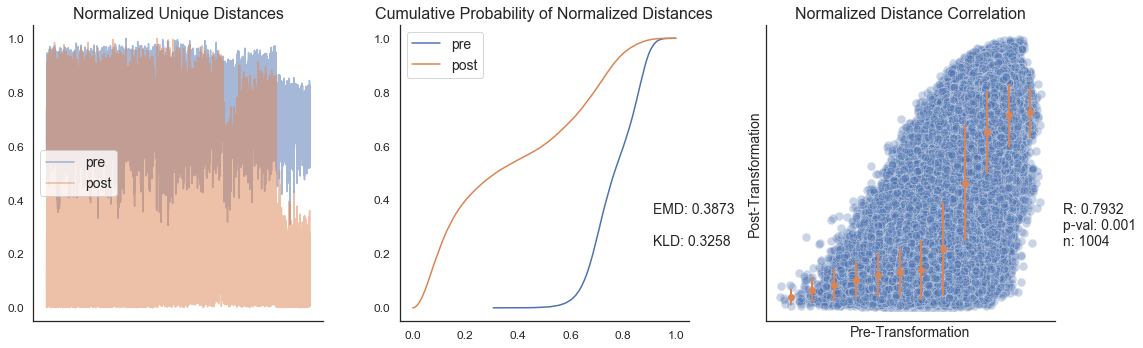

Knn Preservation: 95.9441

CPU times: user 28.5 s, sys: 3.71 s, total: 32.2 s
Wall time: 31.8 s


In [25]:
%%time
# look at 2-component PCA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA2.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA2.knn_graph(k))))

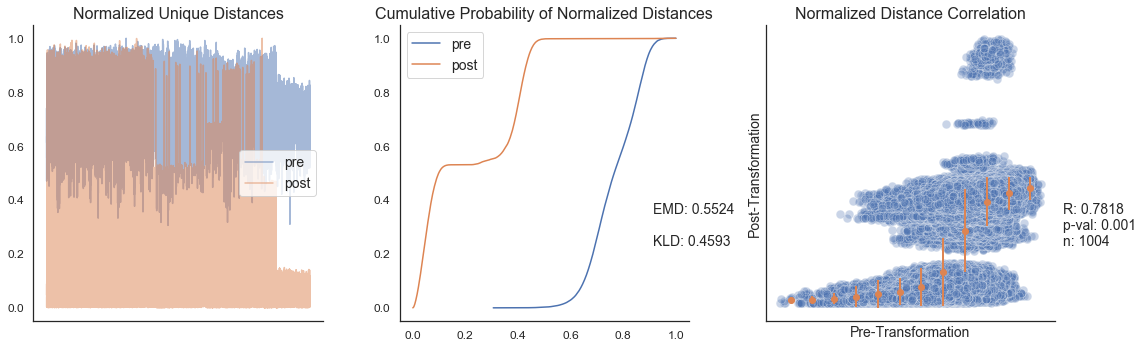

Knn Preservation: 95.5532

CPU times: user 31.5 s, sys: 4.19 s, total: 35.7 s
Wall time: 38.2 s


In [26]:
%%time
# look at t-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_tSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_tSNE.knn_graph(k))))

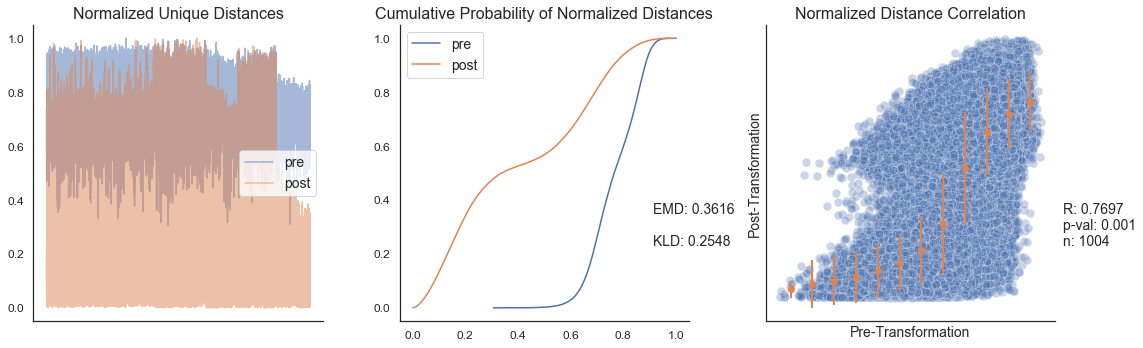

Knn Preservation: 95.5991

CPU times: user 29.4 s, sys: 4.22 s, total: 33.6 s
Wall time: 33.2 s


In [27]:
%%time
# look at FIt-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_FItSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_FItSNE.knn_graph(k))))

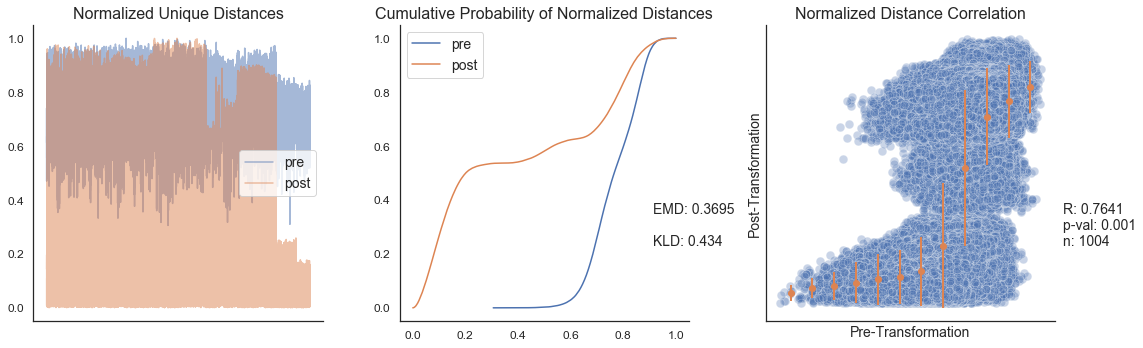

Knn Preservation: 95.2657

CPU times: user 30.2 s, sys: 4.95 s, total: 35.2 s
Wall time: 36.2 s


In [28]:
%%time
# look at UMAP vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_UMAP.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_UMAP.knn_graph(k))))

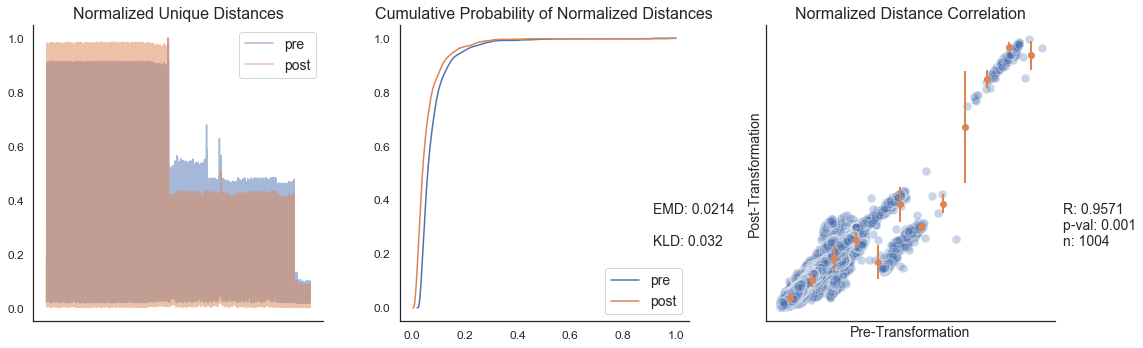

Knn Preservation: 96.6264

CPU times: user 32 s, sys: 3.97 s, total: 36 s
Wall time: 37.4 s


In [29]:
%%time
# look at DCA vs 500-feature dataset 
# transform==None for distance matrix here bc that's the input to DCA
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform=None), 
                                  post=P14Retina_0_DCA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k), 
                                                       post=P14Retina_0_DCA.knn_graph(k))))

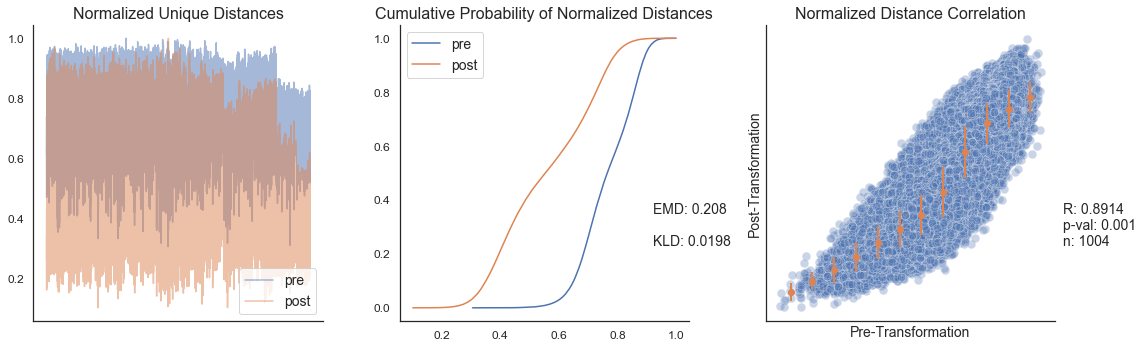

Knn Preservation: 96.8971

CPU times: user 34.6 s, sys: 5.45 s, total: 40 s
Wall time: 42.9 s


In [30]:
%%time
# look at 33-component PCA vs 500-feature dataset to compare to DCA
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA33.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA33.knn_graph(k))))

---
#### 3. repeat for continuous dataset

---
#### 3.0. read in continuous dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30
* _cluster_ and _downsample proportionally_ for future processing

In [31]:
%time qi = RNA_counts.from_file('../inputs/qi_s1_edited_all.csv.gz', cells_axis=0, labels=[None,None])

CPU times: user 17.8 s, sys: 1.53 s, total: 19.3 s
Wall time: 20.7 s


In [32]:
qi.data.shape

(1595, 25507)

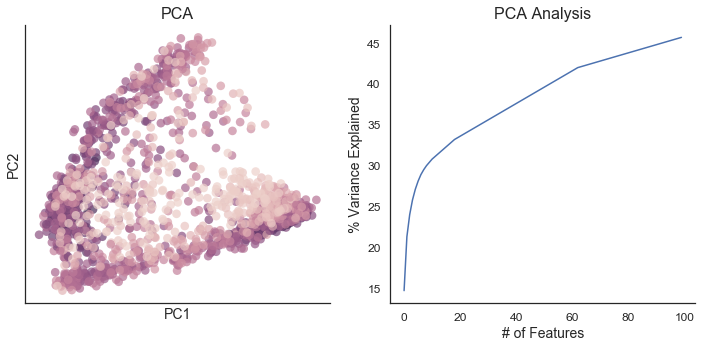

In [33]:
qi_PCA100 = fcc_PCA(qi.arcsinh_norm(norm='l1'), n_components=100)
qi_PCA100.plot()

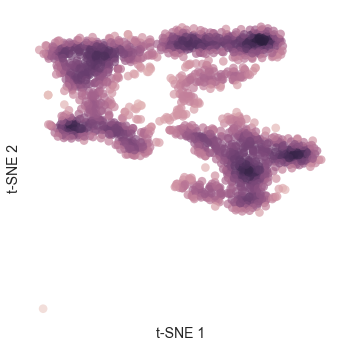

CPU times: user 12.9 s, sys: 451 ms, total: 13.4 s
Wall time: 14 s


In [34]:
%%time 
qi_tSNE = fcc_tSNE(qi_PCA100.results, perplexity=30) # use standard perplexity of 30 here
qi_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x130b08748>)

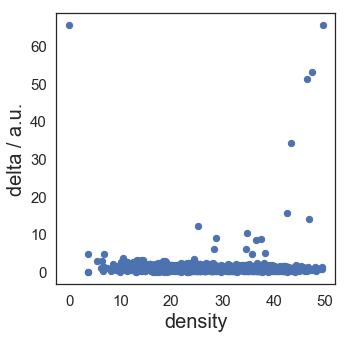

In [35]:
qi_tSNE.clu.draw_decision_graph() # get potential density-peak cluster centers

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x132ad9b38>)

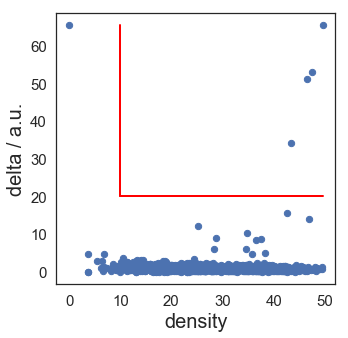

In [36]:
qi_tSNE.clu.assign(10,20) # assign cluster center cutoffs
qi_tSNE.clu.draw_decision_graph(min_delta=qi_tSNE.clu.min_delta, min_density=qi_tSNE.clu.min_density) # plot chosen density-peak cluster centers

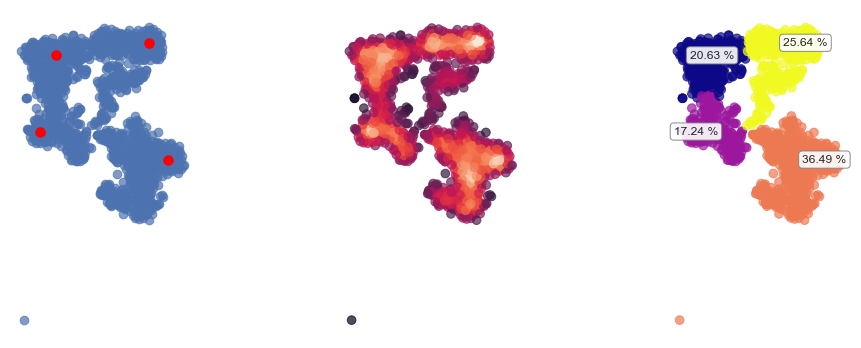

In [37]:
qi_tSNE.plot_clusters() # visualize clustering

In [38]:
print('Silhouette Score: {}\n'.format(qi_tSNE.silhouette_score()))
qi_tSNE.cluster_counts()

Silhouette Score: 0.5196231007575989

329 cells in cluster 0 (20.627 %)

275 cells in cluster 1 (17.241 %)

582 cells in cluster 2 (36.489 %)

409 cells in cluster 3 (25.643 %)



---
#### 3.1. feature-select continuous dataset and perform DRs
* select _500 most variable genes_
* _500-component PCA_ as control comparison to _feature-selected counts data_
* _2-component_ PCA
* _t-SNE_ with perplexity 30
* _UMAP_ with perplexity 30
* _DCA_

In [39]:
# select 500 most variable genes
qi_0 = RNA_counts.var_select(qi, n_features=500) 

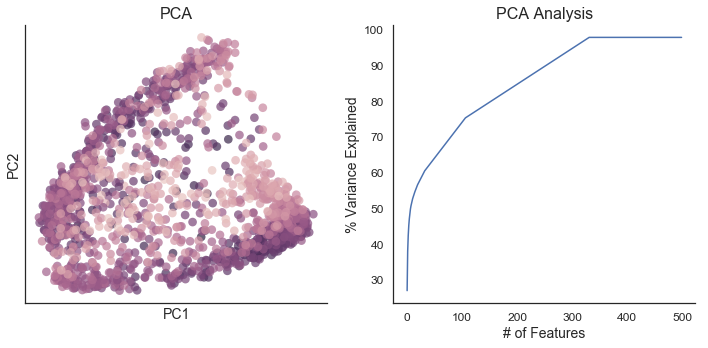

In [40]:
qi_0_PCA500 = fcc_PCA(qi_0.arcsinh_norm(), n_components=500) # 500 component PCA as control
qi_0_PCA500.plot()

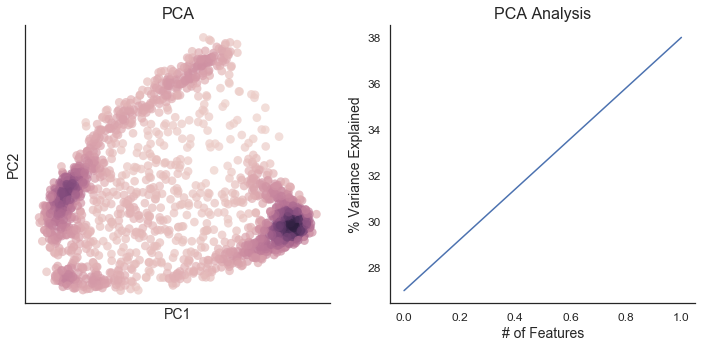

In [41]:
qi_0_PCA2 = fcc_PCA(qi_0.arcsinh_norm(), n_components=2) # 2 component PCA
qi_0_PCA2.plot()

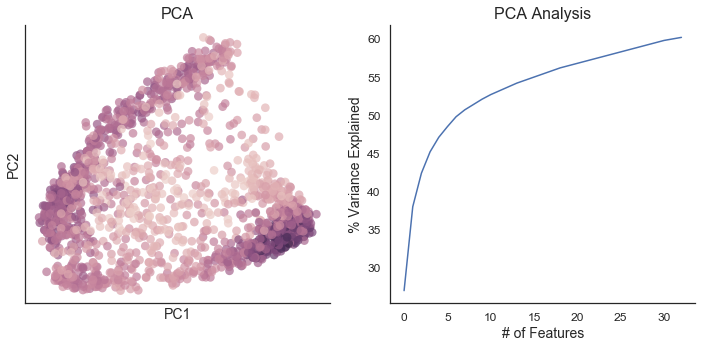

In [42]:
qi_0_PCA33 = fcc_PCA(qi_0.arcsinh_norm(), n_components=33) # 33 component PCA to compare to DCA
qi_0_PCA33.plot()

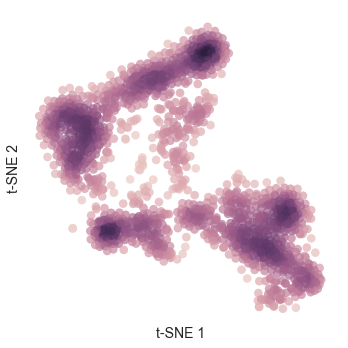

In [43]:
qi_0_tSNE = fcc_tSNE(qi_0.arcsinh_norm(), perplexity=30) # t-SNE with perplexity 30
qi_0_tSNE.plot()

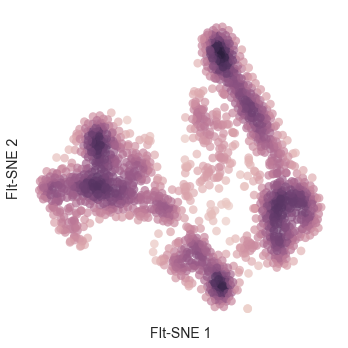

In [44]:
qi_0_FItSNE = fcc_FItSNE(qi_0.arcsinh_norm(), perplexity=30) # FIt-SNE with perplexity 30
qi_0_FItSNE.plot()

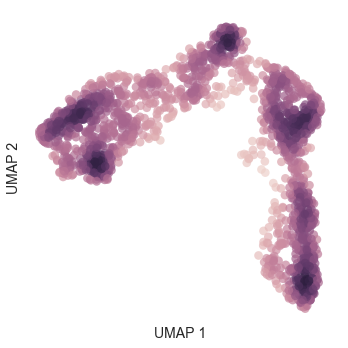

In [45]:
qi_0_UMAP = fcc_UMAP(qi_0.arcsinh_norm(), perplexity=30) # UMAP with perplexity 30
qi_0_UMAP.plot()

In [46]:
qi_0_DCA = fcc_DCA(qi_0.counts, norm=False) # DCA on raw counts

DCA: Successfully preprocessed 500 genes and 1595 cells.
Calculating low dimensional representations...
Calculating reconstructions...


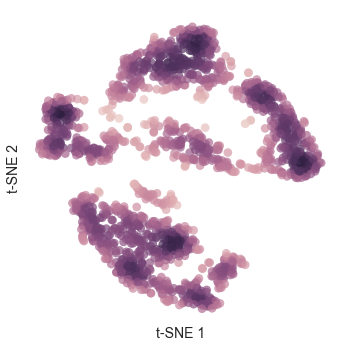

In [47]:
test = RNA_counts(data=qi_0_DCA.results)
qi_0_DCAtSNE = fcc_tSNE(test.arcsinh_norm(), perplexity=30) # t-SNE with perplexity 30
qi_0_DCAtSNE.plot()

---
#### 3.2. compare Euclidean distances and Knn preservation before and after DR transformations
* _arcsinh-transform counts_ before calculating distance matrices for fair comparison to DR outputs
* for DCA, _do not arcsinh-transform_ because raw counts are input

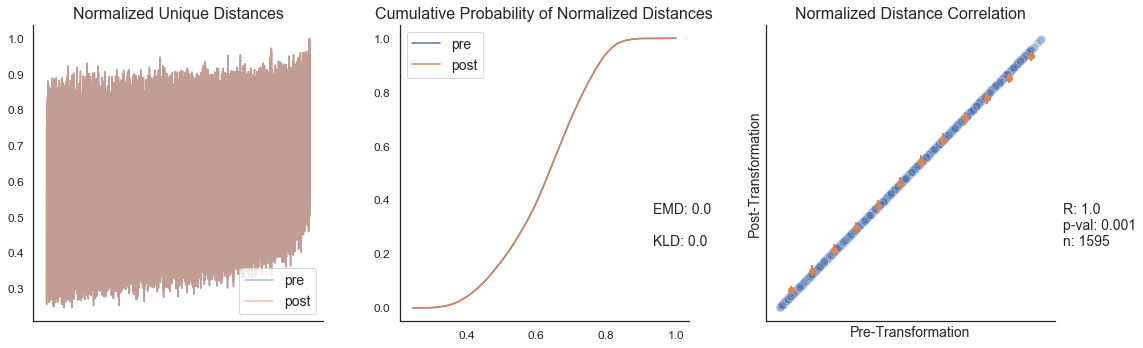

Knn Preservation: 100.0

CPU times: user 1min 39s, sys: 16.7 s, total: 1min 56s
Wall time: 2min 2s


In [48]:
%%time
# look at 500-component PCA vs 500-feature dataset as control. should have perfect correlation and EMD/KLD.
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_PCA500.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_PCA500.knn_graph(k))))

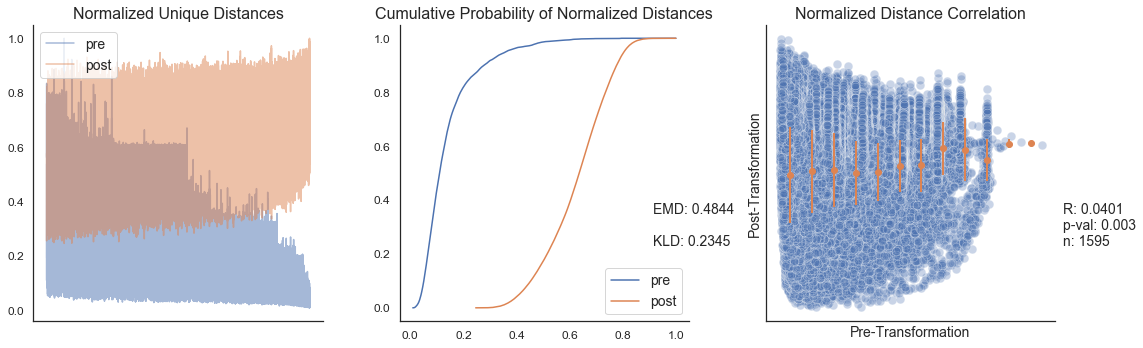

Knn Preservation: 97.1933

CPU times: user 1min 46s, sys: 18.7 s, total: 2min 5s
Wall time: 2min 12s


In [49]:
%%time
# look at arcsinh-transformed vs raw dataset to see how correlation is affected.
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform=None), 
                                  post=qi_0.distance_matrix(transform='arcsinh', scale=1000))
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k), 
                                                       post=qi_0.knn_graph(k, transform='arcsinh', scale=1000))))

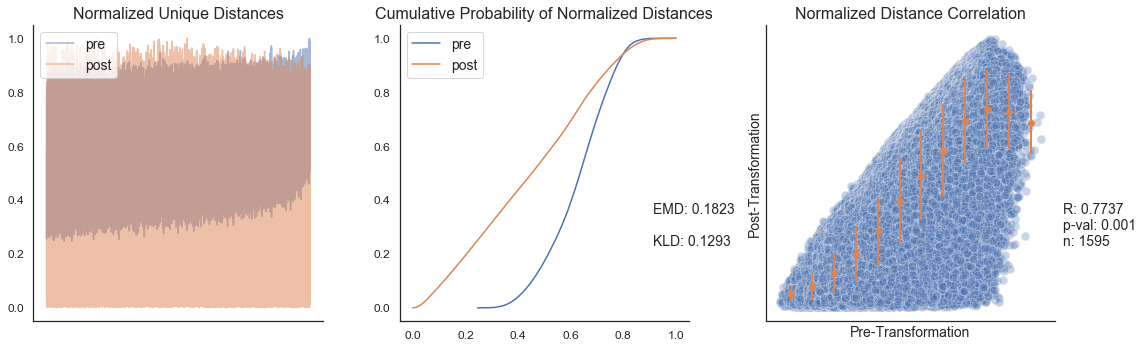

Knn Preservation: 97.7739

CPU times: user 1min 35s, sys: 18 s, total: 1min 53s
Wall time: 2min 9s


In [50]:
%%time
# look at 2-component PCA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_PCA2.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_PCA2.knn_graph(k))))

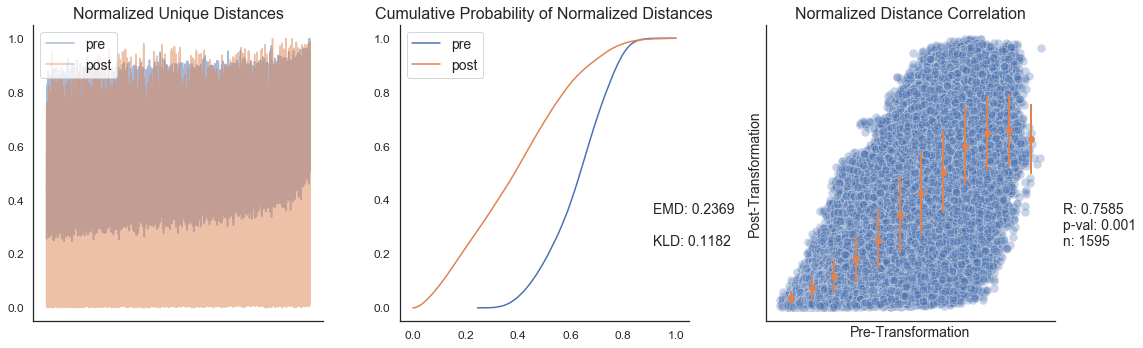

Knn Preservation: 97.6024

CPU times: user 1min 43s, sys: 13.7 s, total: 1min 57s
Wall time: 10min 30s


In [51]:
%%time
# look at t-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_tSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_tSNE.knn_graph(k))))

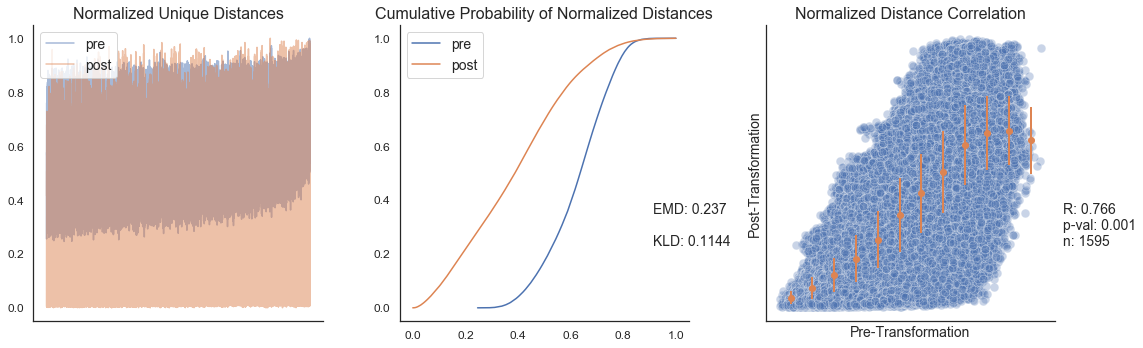

Knn Preservation: 97.6196

CPU times: user 1min 34s, sys: 14.8 s, total: 1min 49s
Wall time: 1min 59s


In [52]:
%%time
# look at FIt-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_FItSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_FItSNE.knn_graph(k))))

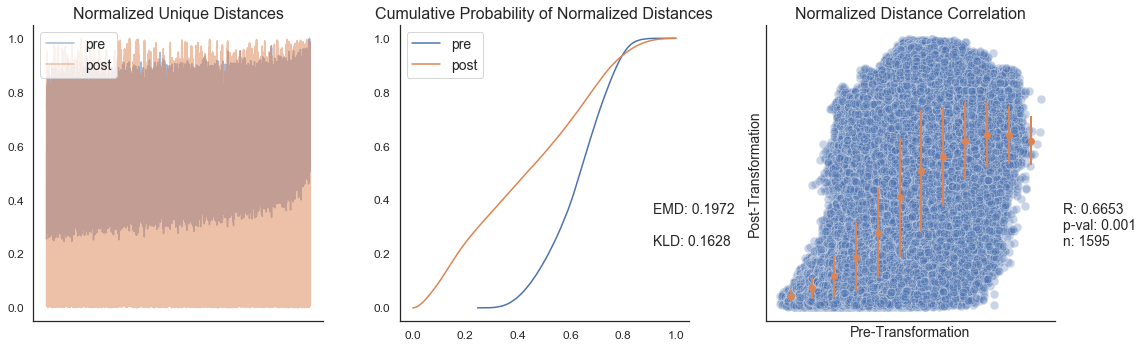

Knn Preservation: 97.4579

CPU times: user 1min 30s, sys: 14.7 s, total: 1min 45s
Wall time: 1min 51s


In [53]:
%%time
# look at UMAP vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_UMAP.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_UMAP.knn_graph(k))))

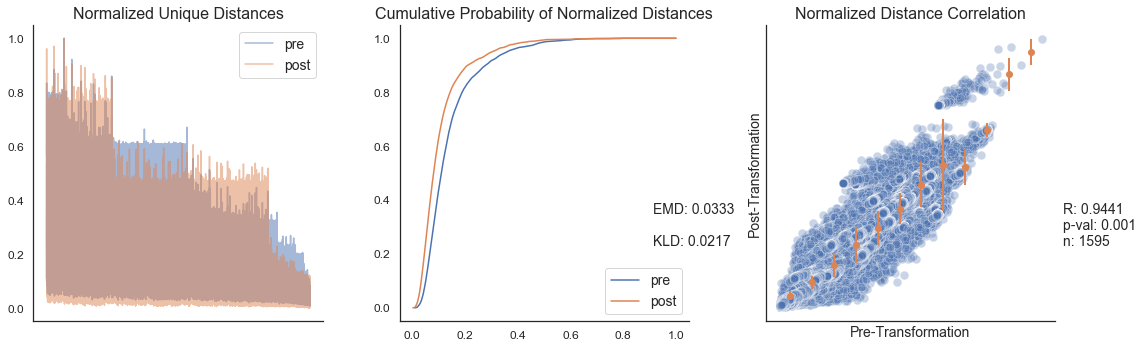

Knn Preservation: 98.1689

CPU times: user 1min 31s, sys: 16.5 s, total: 1min 47s
Wall time: 1min 53s


In [54]:
%%time
# look at DCA vs 500-feature dataset 
# transform==None for distance matrix here bc that's the input to DCA
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform=None), 
                                  post=qi_0_DCA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k), 
                                                       post=qi_0_DCA.knn_graph(k))))

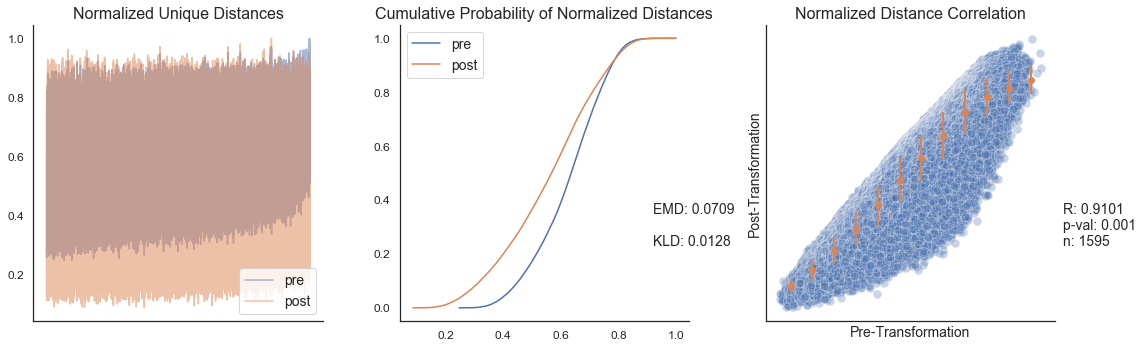

Knn Preservation: 98.3869

CPU times: user 1min 30s, sys: 14.8 s, total: 1min 45s
Wall time: 1min 49s


In [55]:
%%time
# look at 33-component PCA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_PCA33.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_PCA33.knn_graph(k))))